In [ ]:
'''

Given the IMDB movie review dataset (text reviews + binary sentiment labels), create a reproducible pipeline that:

1. Applies a full suite of text preprocessing techniques taught in class (cleaning, tokenization, normalization,  stemming/lemmatization, stopword strategies, etc.).
2.  Use Count Vectorizer for building your feature matrices suitable for a Multinomial Naive Bayes classifier.
3. Trains and validates Multinomial Naive Bayes models using a test set.
4. Quantify the model performance (accuracy, precision, recall, F1, ROC-AUC)

'''


In [23]:
import os


In [24]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../dataset/IMDB Dataset.csv'))

In [26]:
filepath=parent_dir

In [27]:
import pandas as pd 
df=pd.read_csv(filepath)

In [28]:
df.sample(20)

,review,sentiment
24171,Having lived in Japan for several years this m...,negative
22717,This is precious. Everything Is Illuminated is...,positive
47733,"After seeing Meredith in ""Beyond the Prairie"" ...",positive
4313,"all i can say is that each time i see CONRACK,...",positive
10544,"After all these years, I am puzzled as to why ...",positive
49388,"Based on the idea from Gackt, Moon Child took ...",positive
44224,SPOILERS THROUGH: <br /><br />I really am in t...,positive
46005,"I liked this movie a lot, but the feeling that...",positive
23379,"""Nuts in May"" may be one of the worst films i ...",negative
918,"I know little or nothing about astronomy, but ...",positive


In [29]:
label={
    'positive': 1,
    'negative' :0,
}

df['sentiment_label']=df['sentiment'].map(label)

In [30]:
df.sample(10)

,review,sentiment,sentiment_label
12178,This is another fantasy favorite from Ralph Ba...,positive,1
28874,I have to say I was very curious on viewing th...,negative,0
18130,The best bond game made of all systems. It was...,positive,1
38591,Director/screenwriter Allan Burns seems to hav...,negative,0
26744,I was not impressed about this film especially...,negative,0
49769,I've been a fan of Jim Henson and his characte...,negative,0
41068,I guess this would be a great movie for a true...,negative,0
15952,This film is too good for words. Its so unbeli...,positive,1
29587,I think the movie was one sided I watched it r...,negative,0
47602,I first saw Rob Roy twelve years ago. With lit...,positive,1


In [31]:
# Step 2: Text Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
import spacy
from nltk.stem import PorterStemmer

# Initialize NLTK Stemmer
stemmer = PorterStemmer()

# Initialize SpaCy model (disable parser and ner for speed since we only need lemmatization)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def preprocess_text(text):
    """
    Preprocess a text string:
    1. Convert to lowercase
    2. Tokenize into words
    3. Remove punctuation
    4. Remove stopwords (common words like 'the', 'is', 'and')
    
    Args:
        text (str): Input text to preprocess
    
    Returns:
        str: Cleaned and preprocessed text
    """
    # Convert to lowercase
    text = text.lower()
    # text with normalization challenges
    text = ' '.join(text.split())
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters (keep only letters, numbers, and basic punctuation)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"]+', '', text)
    


    # Tokenize: split text into individual words
    tokens = word_tokenize(text)
    
    # Remove punctuation and stopwords
    stop_words = set(stopwords.words('english'))
    
    # Filter out stopwords and punctuation
    cleaned_tokens = [
        word for word in tokens 
        if word not in stop_words and word not in string.punctuation
    ]
    
    # Join tokens back into a string
    return ' '.join(cleaned_tokens)

# Apply preprocessing to all reviews
df['cleaned_review'] = df['review'].apply(preprocess_text)

print("Before and After Preprocessing:")
print("=" * 80)
for idx, row in df[:5].iterrows():
    print(f"\nOriginal: {row['review']}")
    print(f"Cleaned:  {row['cleaned_review']}")
    print("-" * 80)

Before and After Preprocessing:

Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say th

In [32]:
import spacy
from nltk.stem import PorterStemmer

# Initialize NLTK Stemmer
stemmer = PorterStemmer()

# Initialize SpaCy model (disable parser and ner for speed since we only need lemmatization)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def get_stemmed_text(text):
    """
    Uses NLTK PorterStemmer.
    Aggressively chops words. e.g., 'generous' -> 'gener'
    """
    tokenized_text = text.split() # Simple split since it's already cleaned
    stemmed_words = [stemmer.stem(word) for word in tokenized_text]
    return ' '.join(stemmed_words)

def get_lemmatized_text(text):
    """
    Uses SpaCy.
    Reduces words to dictionary root. e.g., 'generous' -> 'generous', 'was' -> 'be'
    """
    doc = nlp(text)
    # .lemma_ returns the root form
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

# --- Apply to DataFrame ---
print("Generating Stems and Lemmas... (SpaCy might take a moment)")

# 1. Create Stemmed Column
df['review_stem'] = df['cleaned_review'].apply(get_stemmed_text)

# 2. Create Lemmatized Column
df['review_lemma'] = df['cleaned_review'].apply(get_lemmatized_text)

# --- Comparison ---
print("\nComparison of Text Processing:")
print("=" * 100)
# Let's look at a specific example where they might differ
# We display the first 5 rows
pd.set_option('display.max_colwidth', 50) # Set visual width to see more text
print(df[['cleaned_review', 'review_stem', 'review_lemma']].head())

Generating Stems and Lemmas... (SpaCy might take a moment)

Comparison of Text Processing:
                                      cleaned_review  \
0  one reviewers mentioned watching 1 oz episode ...   
1  wonderful little production br br filming tech...   
2  thought wonderful way spend time hot summer we...   
3  basically 's family little boy jake thinks 's ...   
4  petter mattei 's `` love time money '' visuall...   

                                         review_stem  \
0  one review mention watch 1 oz episod 'll hook ...   
1  wonder littl product br br film techniqu unass...   
2  thought wonder way spend time hot summer weeke...   
3  basic 's famili littl boy jake think 's zombi ...   
4  petter mattei 's `` love time money '' visual ...   

                                        review_lemma  
0  one reviewer mention watch 1 oz episode will h...  
1  wonderful little production br br filming tech...  
2  think wonderful way spend time hot summer week...  
3  basically 's

In [33]:
# Step 3: Feature Extraction - Convert text to numbers
# We'll use CountVectorizer (Bag of Words approach)
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the vectorizer
# This will create a vocabulary of all unique words and count their occurrences
vectorizer = CountVectorizer()
vectorizer1 = CountVectorizer()
vectorizer2 = CountVectorizer()
# Fit the vectorizer on our cleaned reviews and transform them to numerical vectors
X = vectorizer.fit_transform(df['cleaned_review'])
X1=vectorizer1.fit_transform(df['review_stem'])
X2=vectorizer2.fit_transform(df['review_lemma'])
# Get the feature names (vocabulary)
feature_names = vectorizer.get_feature_names_out()
feature_names1 = vectorizer1.get_feature_names_out()
feature_names2 = vectorizer2.get_feature_names_out()

print('Simple ')
print(f"Vocabulary size: {len(feature_names)} unique words\n")



print('using stemming')
print(f"Vocabulary size: {len(feature_names1)} unique words\n")

print('using lemmatization')
print(f"Vocabulary size: {len(feature_names2)} unique words\n")



Simple 
Vocabulary size: 141223 unique words

using stemming
Vocabulary size: 116617 unique words

using lemmatization
Vocabulary size: 129556 unique words



In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

y = df['sentiment_label'] 

# 2. Split Data (You did this correctly, we just need to use them now!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train1, X_test1, _, _ = train_test_split(X1, y, test_size=0.2, random_state=42)
X_train2, X_test2, _, _ = train_test_split(X2, y, test_size=0.2, random_state=42)

# 3. Train Models (FIT ON TRAIN DATA ONLY)
clf_simple = MultinomialNB()
clf_simple.fit(X_train, y_train)

clf_stem = MultinomialNB()
clf_stem.fit(X_train1, y_train)

clf_lemma = MultinomialNB()
clf_lemma.fit(X_train2, y_train)

# 4. Predict (PREDICT ON TEST DATA)
# We use the specific classifier for its specific data type
pred_simple = clf_simple.predict(X_test)
pred_stem   = clf_stem.predict(X_test1)
pred_lemma  = clf_lemma.predict(X_test2)

# 5. Evaluate Accuracy
print("=" * 60)
print(f"Accuracy (Simple): {accuracy_score(y_test, pred_simple):.4f}")
print(f"Accuracy (Stemmed): {accuracy_score(y_test, pred_stem):.4f}")
print(f"Accuracy (Lemma):   {accuracy_score(y_test, pred_lemma):.4f}")
print("=" * 60)

# 6. Detailed Classification Report (Example for Lemmatization)
print("\nDetailed Report for Lemmatization Model:")
print(classification_report(y_test, pred_lemma))

Accuracy (Simple): 0.8615
Accuracy (Stemmed): 0.8579
Accuracy (Lemma):   0.8564

Detailed Report for Lemmatization Model:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      4961
           1       0.87      0.84      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



ROC-AUC Score: 0.9294


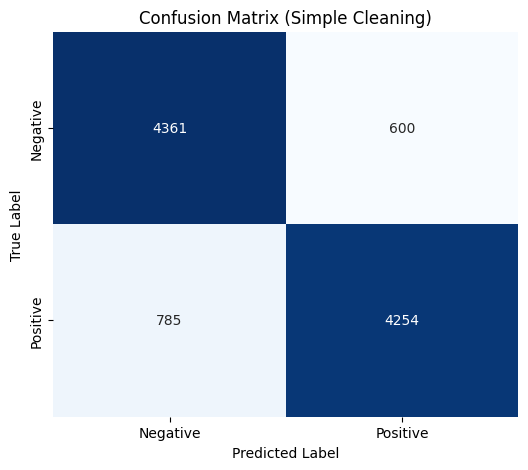

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# Get probabilities for the positive class (class 1)
# simple_clf was trained in the previous step
y_proba = clf_simple.predict_proba(X_test)[:, 1]

# 1. Calculate ROC-AUC Score
auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {auc_score:.4f}")

# 2. Plot Confusion Matrix
cm = confusion_matrix(y_test, pred_simple)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Simple Cleaning)')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Training TF-IDF Model...")

# 1. Initialize TF-IDF Vectorizer
# We use the 'cleaned_review' column since it performed best
tfidf_vectorizer = TfidfVectorizer()

# 2. Transform the text
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_review'])

# 3. Split Data (Stratify ensures balanced classes)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, df['sentiment_label'], test_size=0.2, random_state=42, stratify=df['sentiment_label']
)

# 4. Train Multinomial Naive Bayes
clf_tfidf = MultinomialNB()
clf_tfidf.fit(X_train_tfidf, y_train)

# 5. Evaluate
pred_tfidf = clf_tfidf.predict(X_test_tfidf)
acc_tfidf = accuracy_score(y_test, pred_tfidf)

print("\n" + "="*40)
print(f"Simple Count Accuracy: 0.8615 (Benchmark)")
print(f"TF-IDF Accuracy:       {acc_tfidf:.4f}")
print("="*40)

# Check if we improved
if acc_tfidf > 0.8615:
    print("SUCCESS: TF-IDF improved the model!")
else:
    print("RESULT: TF-IDF did not improve the model.")

Training TF-IDF Model...

Simple Count Accuracy: 0.8615 (Benchmark)
TF-IDF Accuracy:       0.8707
SUCCESS: TF-IDF improved the model!


In [37]:
print("Training TF-IDF with Bigrams...")

# 1. Initialize TF-IDF with N-grams
# ngram_range=(1, 2) means: "Look for single words AND pairs of words"
tfidf_ngram = TfidfVectorizer(ngram_range=(1, 2))

# 2. Transform
X_ngram = tfidf_ngram.fit_transform(df['cleaned_review'])

# 3. Split
X_train_ng, X_test_ng, y_train, y_test = train_test_split(
    X_ngram, df['sentiment_label'], test_size=0.2, random_state=42, stratify=df['sentiment_label']
)

# 4. Train
clf_ngram = MultinomialNB()
clf_ngram.fit(X_train_ng, y_train)

# 5. Evaluate
pred_ngram = clf_ngram.predict(X_test_ng)
acc_ngram = accuracy_score(y_test, pred_ngram)

print("\n" + "="*40)
print(f"TF-IDF (Unigrams): {acc_tfidf:.4f}")
print(f"TF-IDF (Bigrams):  {acc_ngram:.4f}")
print("="*40)

if acc_ngram > acc_tfidf:
    print("SUCCESS: Context (Bigrams) improved the model!")
else:
    print("RESULT: Bigrams didn't help (or added too much noise).")

Training TF-IDF with Bigrams...

TF-IDF (Unigrams): 0.8707
TF-IDF (Bigrams):  0.8909
SUCCESS: Context (Bigrams) improved the model!


In [38]:
from sklearn.linear_model import LogisticRegression

print("Training Logistic Regression on Bigram TF-IDF Features...")

# 1. Initialize Logistic Regression
# C=1.0 is the regularization strength. Smaller C = stronger regularization (prevents overfitting)
log_reg_ng = LogisticRegression(max_iter=1000, C=1.0, random_state=42)

# 2. Train on the Bigram data you just created (X_train_ng)
log_reg_ng.fit(X_train_ng, y_train)

# 3. Predict and Evaluate
pred_log_ng = log_reg_ng.predict(X_test_ng)
acc_log_ng = accuracy_score(y_test, pred_log_ng)

print("\n" + "="*45)
print(f"Naive Bayes (Bigrams):        0.8909")
print(f"Logistic Regression (Bigrams): {acc_log_ng:.4f}")
print("="*45)

# --- The "Magic" Part: Inspecting Learned Phrases ---
# Get the feature names (words and phrases)
feature_names = tfidf_ngram.get_feature_names_out()
coefficients = log_reg_ng.coef_[0]

coef_df = pd.DataFrame({'Phrase': feature_names, 'Coefficient': coefficients})

# Sort to find the most influential phrases
top_positive = coef_df.sort_values(by='Coefficient', ascending=False).head(10)
top_negative = coef_df.sort_values(by='Coefficient', ascending=True).head(10)

print("\nTop 10 Most POSITIVE Phrases:")
print(top_positive)

print("\nTop 10 Most NEGATIVE Phrases:")
print(top_negative)

Training Logistic Regression on Bigram TF-IDF Features...

Naive Bayes (Bigrams):        0.8909
Logistic Regression (Bigrams): 0.8958

Top 10 Most POSITIVE Phrases:
            Phrase  Coefficient
1276989      great    10.942139
980112   excellent     8.276601
301334        best     6.837873
3241769  wonderful     6.050952
2142089    perfect     6.040197
1732974       love     5.896897
129601     amazing     5.789907
1736957      loved     5.449114
3191330       well     5.355308
1179086        fun     5.215730

Top 10 Most NEGATIVE Phrases:
           Phrase  Coefficient
244264        bad   -12.117377
3261460     worst   -11.299266
233306      awful    -8.574609
3163973     waste    -7.739420
353762     boring    -7.685627
2009640   nothing    -7.179298
2906279  terrible    -7.100265
2218330      poor    -7.020895
955208       even    -5.855419
2812380    stupid    -5.845052


In [ ]:
new_reviews = [
    "This is an excellent movie with great performances!",
    "Awful experience, very disappointing.",
    "Absolutely loved it, highly recommended!"
]

print("Testing with New Reviews:")
print("=" * 80)

In [39]:
# The new data
new_reviews = [
    "This is an excellent movie with great performances!",
    "Awful experience, very disappointing.",
    "Absolutely loved it, highly recommended!",
    "It was okay, not the best but certainly not the worst.", # Added a tricky neutral one
    "I expected to hate it, but I was pleasantly surprised." # Added a tricky mixed sentiment
]

print("Testing with New Reviews:")
print("=" * 80)

# 1. Apply the SAME preprocessing
cleaned_new_reviews = [preprocess_text(r) for r in new_reviews]

# 2. Apply the SAME vectorizer (Transform only!)
# We use the 'tfidf_ngram' vectorizer because that's what 'log_reg_ng' expects
X_new = tfidf_ngram.transform(cleaned_new_reviews)

# 3. Predict using the Logistic Regression model
new_predictions = log_reg_ng.predict(X_new)
new_probs = log_reg_ng.predict_proba(X_new)

# 4. Display Results
for i, review in enumerate(new_reviews):
    sentiment = "Positive" if new_predictions[i] == 1 else "Negative"
    confidence = new_probs[i].max() * 100 # Get the probability of the predicted class
    
    print(f"Review: {review}")
    print(f"Prediction: {sentiment} ({confidence:.2f}% confidence)")
    print("-" * 50)

Testing with New Reviews:
Review: This is an excellent movie with great performances!
Prediction: Positive (99.88% confidence)
--------------------------------------------------
Review: Awful experience, very disappointing.
Prediction: Negative (96.73% confidence)
--------------------------------------------------
Review: Absolutely loved it, highly recommended!
Prediction: Positive (98.21% confidence)
--------------------------------------------------
Review: It was okay, not the best but certainly not the worst.
Prediction: Negative (79.18% confidence)
--------------------------------------------------
Review: I expected to hate it, but I was pleasantly surprised.
Prediction: Positive (86.66% confidence)
--------------------------------------------------


In [41]:
try:
    os.makedirs('model', exist_ok=True)
    print(f"Directory  created or already existed.")
except OSError as e:
    print(f"An error occurred: {e}")

Directory  created or already existed.


In [42]:
import joblib
import pickle

print("Saving artifacts...")

# --- Method 1: Using Joblib (Recommended for Scikit-Learn) ---
# Joblib is often faster and more efficient for objects containing large numpy arrays
joblib.dump(log_reg_ng, 'model/imdb_sentiment_model.joblib')
joblib.dump(tfidf_ngram, 'model/imdb_tfidf_vectorizer.joblib')
print("Saved using Joblib: .joblib files created.")

# --- Method 2: Using Pickle (Standard Python) ---
# Pickle is the standard Python way to serialize objects
with open('imdb_sentiment_model.pkl', 'wb') as f:
    pickle.dump(log_reg_ng, f)

with open('imdb_tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_ngram, f)
print("Saved using Pickle: .pkl files created.")

print("\nAll files saved successfully!")

Saving artifacts...
Saved using Joblib: .joblib files created.
Saved using Pickle: .pkl files created.

All files saved successfully!


In [43]:
import pandas as pd
import re
import string
import joblib

# NLTK Imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# sklearn Imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# --- 1. GLOBAL INITIALIZATION (Run once) ---
# Download necessary NLTK data (if not already present)
nltk.download('punkt')
nltk.download('stopwords')

# Initialize these OUTSIDE the function so they are created only once
my_stemmer = PorterStemmer()
my_stop_words = set(stopwords.words('english'))

# --- 2. Define the Preprocessing Function ---
# It uses the global 'my_stemmer' and 'my_stop_words'
def preprocess_text(text_list):
    clean_data = []
    for text in text_list:
        # 1. Lowercase & Normalization
        text = text.lower()
        text = ' '.join(text.split())
        
        # 2. Remove URLs, Handles, Special Characters
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"]+', '', text)
        
        # 3. Tokenize
        tokens = word_tokenize(text)
        
        # 4. Stem & Remove Stopwords
        # Uses the global variables defined above
        cleaned_tokens = [
            my_stemmer.stem(word) for word in tokens 
            if word not in my_stop_words and word not in string.punctuation
        ]
        clean_data.append(' '.join(cleaned_tokens))
    
    return clean_data

# --- 3. Build & Train Pipeline ---
# validate=False is required for text data
cleaner = FunctionTransformer(preprocess_text, validate=False)

pipeline = Pipeline([
    ('cleaner', cleaner),
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, random_state=42))
])

print("Training pipeline...")
# Assuming 'df' is your dataframe from previous steps
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['review'], df['sentiment_label'], 
    test_size=0.2, random_state=42, stratify=df['sentiment_label']
)

pipeline.fit(X_train_raw, y_train)

# --- 4. Save ---
joblib.dump(pipeline, 'sentiment_pipeline.joblib')
print("✅ Pipeline saved successfully as 'sentiment_pipeline.joblib'")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lb368\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lb368\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training pipeline...
✅ Pipeline saved successfully as 'sentiment_pipeline.joblib'
